<a href="https://colab.research.google.com/github/Taweilo/credit_risk_modeling/blob/main/Code_Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
# data preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb

from sklearn.metrics import precision_recall_fscore_support

## 1. Import data

In [90]:
url = "https://raw.githubusercontent.com/Taweilo/credit_risk_modeling/main/loan_data.csv"
df = pd.read_csv(url)
df.head()

,application_id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,1,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,2,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,3,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,4,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,5,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [91]:
print(df.shape)
print("")
print(df.describe())

(32581, 13)

       application_id    person_age  person_income  person_emp_length  \
count    32581.000000  32581.000000   3.258100e+04       31686.000000   
mean     16291.000000     27.734600   6.607485e+04           4.789686   
std       9405.468897      6.348078   6.198312e+04           4.142630   
min          1.000000     20.000000   4.000000e+03           0.000000   
25%       8146.000000     23.000000   3.850000e+04           2.000000   
50%      16291.000000     26.000000   5.500000e+04           4.000000   
75%      24436.000000     30.000000   7.920000e+04           7.000000   
max      32581.000000    144.000000   6.000000e+06         123.000000   

          loan_amnt  loan_int_rate   loan_status  loan_percent_income  \
count  32581.000000   29465.000000  32581.000000         32581.000000   
mean    9589.371106      11.011695      0.218164             0.170203   
std     6322.086646       3.240459      0.413006             0.106782   
min      500.000000       5.420000   

In [92]:
print(df.info())
print("")
# Assuming df is your DataFrame
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    print(f"Column '{col}' has data type 'object'.")
    unique_values = df[col].unique()
    print("Unique values:")
    for val in unique_values:
        print(val)
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   application_id              32581 non-null  int64  
 1   person_age                  32581 non-null  int64  
 2   person_income               32581 non-null  int64  
 3   person_home_ownership       32581 non-null  object 
 4   person_emp_length           31686 non-null  float64
 5   loan_intent                 32581 non-null  object 
 6   loan_grade                  32581 non-null  object 
 7   loan_amnt                   32581 non-null  int64  
 8   loan_int_rate               29465 non-null  float64
 9   loan_status                 32581 non-null  int64  
 10  loan_percent_income         32581 non-null  float64
 11  cb_person_default_on_file   32581 non-null  object 
 12  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(6), object

In [93]:
print("How many customers whose employment length are above 40 years: ",len(df[df['person_emp_length']>40]))
print("")
print(df[df['person_emp_length']>40]['person_emp_length'])

How many customers whose employment length are above 40 years:  3

0        123.0
210      123.0
32355     41.0
Name: person_emp_length, dtype: float64


In [94]:
print("How many customers are above 100 years old: ",len(df[df['person_age']>100]))
print("")
print(df[df['person_age']>100]['person_age'])

How many customers are above 100 years old:  5

81       144
183      144
575      123
747      123
32297    144
Name: person_age, dtype: int64


In [95]:
df.loan_status.value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

Data issue:<br>
1. no need of application ID
2. missing data: person_emp_length, loan_int_rate
3. data quality: employment lenght and age above 100 years are abnormal
4. imbalance data: nondefault data is more than three times of default data

In [96]:
# drop ID
df = df.drop(["application_id"], axis = 1)


In [97]:
# Create the cross table for loan status, home ownership, and the max employment length
print(pd.crosstab(df['loan_status'],df['person_home_ownership'],
                  values=df['person_emp_length'], aggfunc='max'))

# Create an array of indices where employment length is greater than 100
indices = df[df['person_emp_length'] > 100].index

# Drop the records from the data based on the indices and create a new dataframe
df_new = df.drop(indices)

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         123.0   24.0  31.0   41.0
1                          34.0   11.0  17.0  123.0


In [98]:
# Use Pandas to drop the record from the data frame and create a new one
df_new = df.drop(df[df["person_age"] > 100].index)


In [99]:
print(pd.crosstab(df_new["loan_intent"], df["loan_status"], margins = True))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5340  1111   6451
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4422  1098   5520
VENTURE             4870   847   5717
All                25468  7108  32576


Index(['person_emp_length', 'loan_int_rate'], dtype='object')
     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000           5.42            1   
222          EDUCATION          B      35000          12.42            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000          10.74            1   
408          EDUCATION          C       2250          15.27            0   

     loan_percent_income cb_pe

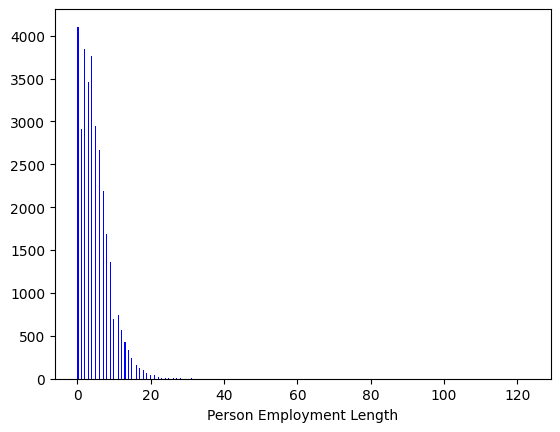

In [100]:
# Print a null value column array
print(df_new.columns[df_new.isnull().any()])

# Print the top five rows with nulls for employment length
print(df_new[df_new["person_emp_length"].isnull()].head())

# Impute the null values with the median value for all employment lengths
df_new["person_emp_length"].fillna((df_new['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(df_new["person_emp_length"], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [101]:
# Print the number of nulls
print(df_new["loan_int_rate"].isnull().sum())

# Store the array on indices
indices = df_new[df_new["loan_int_rate"].isnull()].index

# Save the new data without missing data
df_clean = df_new.drop(indices)

3115


In [102]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29461 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29461 non-null  int64  
 1   person_income               29461 non-null  int64  
 2   person_home_ownership       29461 non-null  object 
 3   person_emp_length           29461 non-null  float64
 4   loan_intent                 29461 non-null  object 
 5   loan_grade                  29461 non-null  object 
 6   loan_amnt                   29461 non-null  int64  
 7   loan_int_rate               29461 non-null  float64
 8   loan_status                 29461 non-null  int64  
 9   loan_percent_income         29461 non-null  float64
 10  cb_person_default_on_file   29461 non-null  object 
 11  cb_person_cred_hist_length  29461 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


## Split data

In [103]:
X = df_clean.drop('loan_status', axis=1)  # 'loan_status' is the target column
X = pd.get_dummies(X, drop_first=True)  # Set drop_first=True to avoid multicollinearity
y = df_clean['loan_status']

In [104]:
X.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22,59000,123.0,35000,16.02,0.59,3,False,False,True,...,False,True,False,False,False,True,False,False,False,True
1,21,9600,5.0,1000,11.14,0.10,2,False,True,False,...,False,False,False,True,False,False,False,False,False,False
2,25,9600,1.0,5500,12.87,0.57,3,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23,65500,4.0,35000,15.23,0.53,2,False,False,True,...,True,False,False,False,True,False,False,False,False,False
4,24,54400,8.0,35000,14.27,0.55,4,False,False,True,...,True,False,False,False,True,False,False,False,False,True


In [105]:
# Splitting the data into training and temporary sets
X_train, X_tem, y_train, y_tem = train_test_split(X, y, test_size=0.4, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_tem, y_tem, test_size=0.5, random_state=123)

In [106]:
from collections import Counter
# Check the class distribution before undersampling
print("Before Undersampling:", Counter(y_train))

Before Undersampling: Counter({0: 13807, 1: 3869})


In [107]:
from imblearn.under_sampling import RandomUnderSampler
# Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Perform undersampling on train_X and train_y
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("After Undersampling:", Counter(y_train_undersampled))


After Undersampling: Counter({0: 3869, 1: 3869})


In [108]:
# rename original train data
X_old_train = X_train
y_old_train = y_train

# rename undersampling train data
X_train = X_train_undersampled
y_train = y_train_undersampled

In [109]:
# set of train data
print(X_old_train.shape)
print(y_old_train.shape)
print(X_train.shape)
print(y_train.shape)
# validation data
print(X_val.shape)
print(y_val.shape)
# test data
print(X_test.shape)
print(y_test.shape)

(17676, 22)
(17676,)
(7738, 22)
(7738,)
(5892, 22)
(5892,)
(5893, 22)
(5893,)


## Modeling

In [110]:
# logit model
log_model=LogisticRegression(solver='lbfgs')
log_model.fit(X_train, np.ravel(y_train))
y_log_pred = log_model.predict(X_val)
y_log_pred_prob =log_model.predict_proba(X_val)[:, 1]
AUC_log = roc_auc_score(y_val, y_log_pred_prob)
print("AUC score", AUC_log)

AUC score 0.7989165864949241


In [111]:
# logit model with CV

# Define hyperparameters grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Create logistic regression model
log_mode_cv = LogisticRegression()

# Create GridSearchCV object
grid_search = GridSearchCV(log_mode_cv, param_grid, cv=5, scoring='roc_auc')

# Fit the grid search to the data
grid_search.fit(X_train, np.ravel(y_train))

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_log_mode_cv = LogisticRegression(**best_params)
best_log_mode_cv.fit(X_train, y_train)
y_log_cv_pred = best_log_mode_cv.predict(X_val)

# Evaluate the model
AUC_logcv = roc_auc_score(y_val, best_log_mode_cv.predict_proba(X_val)[:, 1])
print("AUC on Logistic CV:", AUC_logcv)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
AUC on Logistic CV: 0.8103711823439417


In [112]:
# xgb model
# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the model
xgb_model.fit(X_train, np.ravel(y_train))

# Make predictions on the test data
y_xgb_pred = xgb_model.predict(X_val)
AUG_xgb = roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1])
print("AUC on XGB:", AUG_xgb)

AUC on XGB: 0.9333730964883339


In [113]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label=y_train)

# Base parameters for XGBoost model (common hyperparameters can go here)
base_params = {'objective': 'binary:logistic', 'seed': 99}

# Define the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7],  # Maximum tree depth
    'eta': [0.01, 0.1, 0.3],  # Learning rate
    'n_estimators': [100, 500, 1000]  # Number of boosting rounds (trees)
}

# Create a GridSearchCV object for XGBoost hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(**base_params),
                           param_grid=param_grid,
                           scoring='roc_auc',  # Use AUC for binary classification
                           cv=n_folds,
                           verbose=1,  # Print progress during tuning
                           n_jobs=-1)  # Use all available CPU cores

# Fit GridSearchCV to the training data
grid_search.fit(X_train, np.ravel(y_train))

# Get the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create the final XGBoost model with the best hyperparameters
final_model = xgb.XGBClassifier(**base_params, **best_params)
final_model.fit(X_train, np.ravel(y_train), eval_metric='auc')  # Early stopping can be integrated here

# Make predictions on validation data
y_xgbcv_pred_prob = final_model.predict_proba(X_val)[:, 1]  # Probability of positive class
y_xgbcv_pred = final_model.predict(X_val)
AUC_xgbcv = roc_auc_score(y_val, y_xgbcv_pred_prob)
print("AUC on Validation Data:", AUC_xgbcv)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'eta': 0.01, 'max_depth': 7, 'n_estimators': 1000}


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


AUC on Validation Data: 0.9329158258427925


In [114]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label=y_train)

params = {'objective': 'binary:logistic',
          'seed': 99, 'eval_metric': 'auc'}

# Create the data frame of cross validations with early stopping
cv_df = xgb.cv(params, DTrain, num_boost_round=1000, nfold=n_folds,
               early_stopping_rounds=early_stopping)

# Get the best iteration
best_iteration = cv_df['test-auc-mean'].idxmax()
print("Best Iteration:", best_iteration)

# Train the final model with the best iteration
final_model = xgb.train(params, DTrain, num_boost_round=best_iteration)

# Now, you can use 'final_model' for predictions on your validation data
DVal = xgb.DMatrix(X_val)
y_pred_val = final_model.predict(DVal)

# Calculate AUC on validation data
auc_val = roc_auc_score(y_val, y_pred_val)
print("AUC on Validation Data:", auc_val)

Best Iteration: 64
AUC on Validation Data: 0.9335232652506271


## Evaluation

In [115]:
# print classification report
# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print("Loistic Regression")
print(classification_report(y_val, y_log_pred, target_names=target_names))
print("")
# Print the gradient boosted tree classification report
print("XGB classifier")
print(classification_report(y_val, y_xgbcv_pred, target_names=target_names))


Loistic Regression
              precision    recall  f1-score   support

 Non-Default       0.92      0.67      0.77      4609
     Default       0.40      0.79      0.53      1283

    accuracy                           0.69      5892
   macro avg       0.66      0.73      0.65      5892
weighted avg       0.81      0.69      0.72      5892


XGB classifier
              precision    recall  f1-score   support

 Non-Default       0.94      0.92      0.93      4609
     Default       0.73      0.79      0.76      1283

    accuracy                           0.89      5892
   macro avg       0.84      0.86      0.85      5892
weighted avg       0.90      0.89      0.89      5892



In [116]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Calculate performance metrics
log_reg_accuracy = round(accuracy_score(y_val, y_log_pred), 2)
log_reg_auc = round(roc_auc_score(y_val, y_log_pred), 2)
log_reg_f1 = round(f1_score(y_val, y_log_pred), 2)

xgb_accuracy = round(accuracy_score(y_val, y_xgbcv_pred), 2)
xgb_auc = round(roc_auc_score(y_val, y_xgbcv_pred), 2)
xgb_f1 = round(f1_score(y_val, y_xgbcv_pred), 2)

# Create a DataFrame
data = {
    'Model': ['Logistic Regression', 'XGB Classifier'],
    'Accuracy': [log_reg_accuracy, xgb_accuracy],
    'AUC': [log_reg_auc, xgb_auc],
    'F1': [log_reg_f1, xgb_f1]
}
performance_df = pd.DataFrame(data)

# Set the Model column as the index
performance_df.set_index('Model', inplace=True)

print(performance_df)

                     Accuracy   AUC    F1
Model                                    
Logistic Regression      0.69  0.73  0.53
XGB Classifier           0.89  0.86  0.76


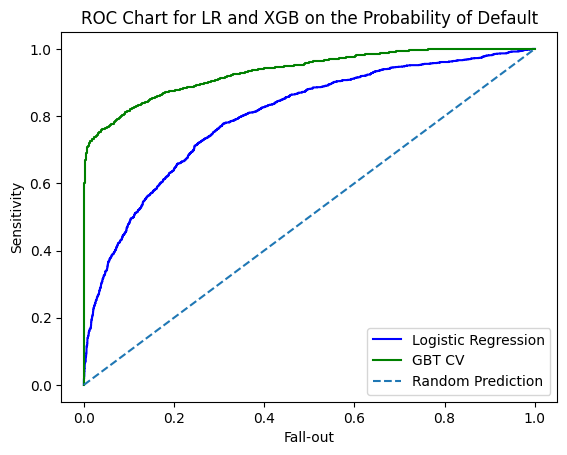

Logistic Regression AUC Score: 0.80
XGB Classifier CV AUC Score: 0.93


In [117]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_val, y_log_pred_prob)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_val, y_xgbcv_pred_prob)

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT CV')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and XGB on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % AUC_log)

# Print the gradient boosted tree AUC with formatting
print("XGB Classifier CV AUC Score: %0.2f" % AUC_xgbcv)

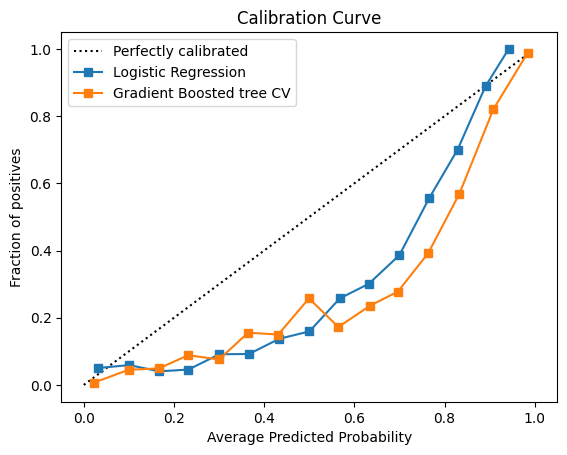

In [118]:
from sklearn.calibration import calibration_curve

# Obtain mean predicted value and fraction of positives for Logistic Regression
prob_true_log, prob_pred_log = calibration_curve(y_val, log_model.predict_proba(X_val)[:, 1], n_bins=15)

# Obtain mean predicted value and fraction of positives for Gradient Boosted Tree
prob_true_xgb, prob_pred_xgb = calibration_curve(y_val, y_xgbcv_pred_prob, n_bins=15)

# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred_log , prob_true_log,
         's-', label='%s' % 'Logistic Regression')
plt.plot(prob_pred_xgb, prob_true_xgb,
         's-', label='%s' % 'Gradient Boosted tree CV')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Brier Score for Classifier 1 (trained with balanced data): 0.19328977171392342
Brier Score for Classifier 2 (trained with imbalanced data): 0.14338685767315354


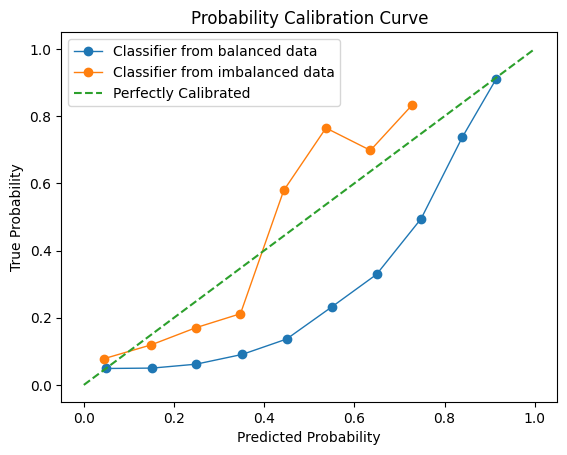

In [119]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss


# Train two logistic regression classifiers
clf = LogisticRegression(max_iter=1000, random_state=42)
clf_r = LogisticRegression(max_iter=1000, random_state=23)
clf.fit(X_train, y_train)
clf_r.fit(X_old_train, y_old_train)

# Probability estimate for both classifiers
prob_pos = clf.predict_proba(X_val)[:, 1]
prob_pos_r = clf_r.predict_proba(X_val)[:, 1]

# Brier Score for both classifiers
b_score = brier_score_loss(y_val, prob_pos)
b_score_r = brier_score_loss(y_val, prob_pos_r)
print("Brier Score for Classifier 1 (trained with balanced data):", b_score)
print("Brier Score for Classifier 2 (trained with imbalanced data):", b_score_r)

# True and Predicted Probabilities for both classifiers
true_pos, pred_pos = calibration_curve(y_val, prob_pos, n_bins=10)
true_pos_r, pred_pos_r = calibration_curve(y_val, prob_pos_r, n_bins=10)

# Plot the Probabilities Calibrated curve for both classifiers
plt.plot(pred_pos, true_pos, marker='o', linewidth=1, label='Classifier from balanced data')
plt.plot(pred_pos_r, true_pos_r, marker='o', linewidth=1, label='Classifier from imbalanced data')

# Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

# Set the title and axis labels for the plot
plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')

# Add a legend to the plot
plt.legend(loc='best')

# Show the plot
plt.show()

## Retrain the model

In [120]:
# Get train+val dataset
# Check the val data
print("Before Undersampling:", Counter(y_val))

# Perform undersampling on train_X and train_y
X_val_undersampled, y_val_undersampled = undersampler.fit_resample(X_val, y_val)

# Check the class distribution after undersampling
print("After Undersampling:", Counter(y_val_undersampled))

# Combine X_train X_val
X_combined_train = np.vstack((X_train, X_val_undersampled))
# Combine y_val under y_train using concatenate
y_combined_train = np.concatenate((y_train, y_val_undersampled))

Before Undersampling: Counter({0: 4609, 1: 1283})
After Undersampling: Counter({0: 1283, 1: 1283})


In [121]:
# retrain the model use the XGB hyperparameter
final_model = xgb.XGBClassifier(**base_params, **best_params)
final_model.fit(X_combined_train, y_combined_train, eval_metric='auc')

# Make predictions on test data
y_xgbcv_test_pred_prob = final_model.predict_proba(X_test)[:, 1]  # Probability of positive class
y_xgbcv_test_pred = final_model.predict(X_test)
AUC_xgbcv_test = roc_auc_score(y_test, y_xgbcv_test_pred_prob)
print("AUC on test Data:", AUC_xgbcv_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


AUC on test Data: 0.9411116501882111


Testing the performance

In [125]:
# Create a DataFrame with y_test
test_summary_df = pd.DataFrame(y_test)
test_summary_df = test_summary_df.rename(columns={'loan_status': 'true_loan_status'})
# Add two more columns from your predictions
test_summary_df['prob_default'] = y_xgbcv_test_pred_prob
test_summary_df['pred_loan_status'] = y_xgbcv_test_pred
test_summary_df['loan_amnt'] = X_test['loan_amnt']

print(test_summary_df ['loan_amnt'].describe())

count     5893.000000
mean      9592.393518
std       6250.730027
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


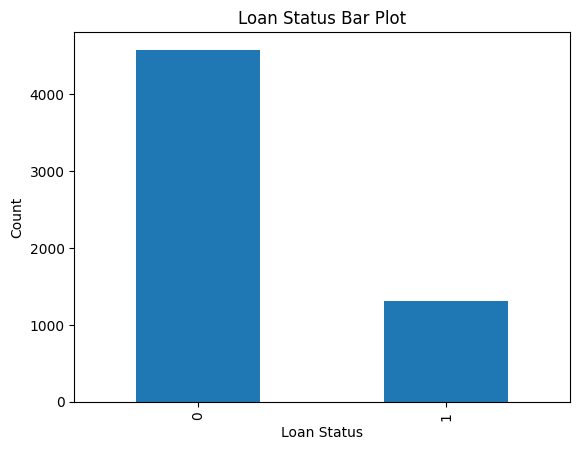

In [126]:
# Get the value counts of 'loan_status'
loan_status_counts = test_summary_df['true_loan_status'].value_counts()

# Plot the bar plot
loan_status_counts.plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Bar Plot')
plt.show()

In [127]:
# classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, y_xgbcv_test_pred, target_names = target_names))

              precision    recall  f1-score   support

 Non-Default       0.94      0.93      0.94      4581
     Default       0.77      0.80      0.78      1312

    accuracy                           0.90      5893
   macro avg       0.85      0.86      0.86      5893
weighted avg       0.90      0.90      0.90      5893



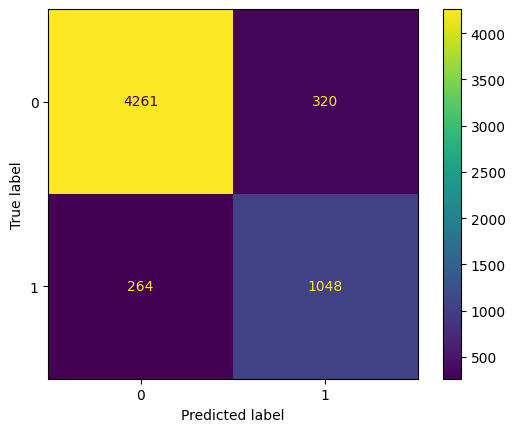

In [128]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_xgbcv_test_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

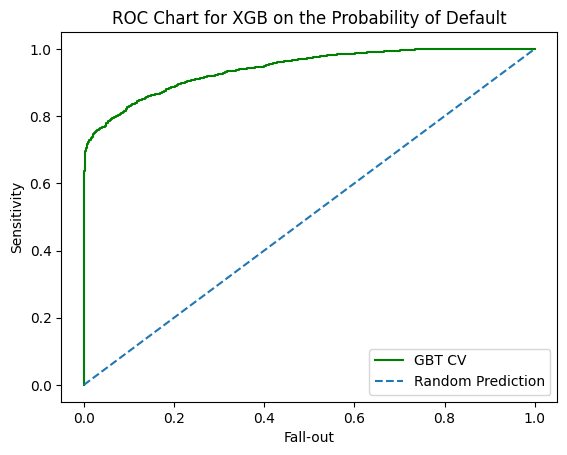

XGB CV AUC Score: 0.94


In [129]:
# ROC chart components
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, y_xgbcv_test_pred_prob)

# ROC Chart with both
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT CV')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for XGB on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Print the gradient boosted tree AUC with formatting
print("XGB CV AUC Score: %0.2f" % AUC_xgbcv_test)

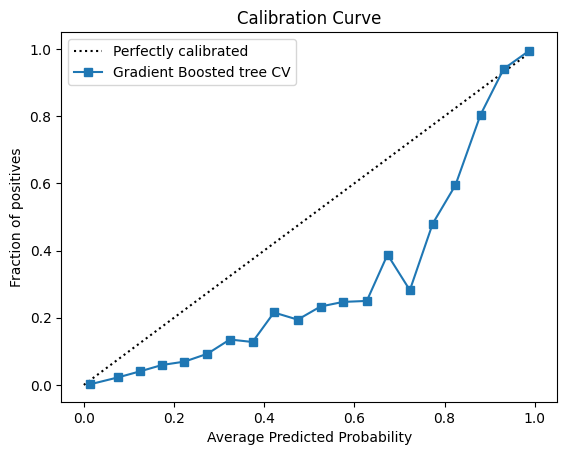

In [130]:
# Obtain mean predicted value and fraction of positives for Gradient Boosted Tree
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_xgbcv_test_pred_prob, n_bins=20)

# Add the calibration curve for the gradient boosted tree
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

plt.plot(prob_pred_xgb, prob_true_xgb,
         's-', label='%s' % 'Gradient Boosted tree CV')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [131]:
# Print or view the DataFrame
print(test_summary_df)

       true_loan_status  prob_default  pred_loan_status  loan_amnt
16239                 0      0.517472                 1       7000
8358                  1      0.880096                 1       7500
14335                 1      0.997370                 1      14500
8104                  0      0.006527                 0      11000
366                   1      0.991953                 1       4375
...                 ...           ...               ...        ...
3555                  0      0.292093                 0       6000
29983                 0      0.121824                 0       8400
28591                 0      0.418470                 0       5000
28763                 0      0.105355                 0      11000
23700                 0      0.142016                 0       9200

[5893 rows x 4 columns]


(array([1726., 1196.,  821.,  476.,  306.,  205.,  125.,   64.,   87.,
         887.]),
 array([2.67479772e-04, 1.00202776e-01, 2.00138077e-01, 3.00073355e-01,
        4.00008649e-01, 4.99943972e-01, 5.99879265e-01, 6.99814558e-01,
        7.99749851e-01, 8.99685144e-01, 9.99620438e-01]),
 <BarContainer object of 10 artists>)

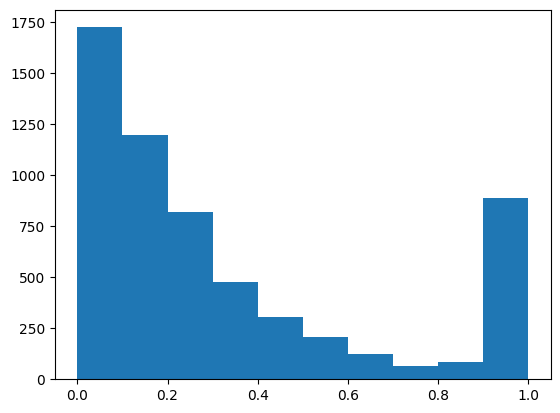

In [132]:
plt.hist(test_summary_df['prob_default'])

In [133]:
## Acceptance rate impact

# Print the statistics of the loan amount column
print(test_summary_df ['loan_amnt'].describe())
print("")
# Store the average loan amount
avg_loan = np.mean(test_summary_df ['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_summary_df ['true_loan_status'],
                 test_summary_df ['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

count     5893.000000
mean      9592.393518
std       6250.730027
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

pred_loan_status              0              1
true_loan_status                              
0                $40,873,188.78  $3,069,565.93
1                 $2,532,391.89 $10,052,828.41


In [134]:
# Reset the format to non-currency format
pd.options.display.float_format = None
# Making the strategy table

accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55,
                0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Create lists to store thresholds and bad rates
thresholds = []
bad_rates = []

# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:

    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_summary_df['prob_default'], \
                         rate).round(3)

    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(test_summary_df['prob_default'],\
                                  rate).round(3))

    # Reassign the loan_status value using the threshold
    test_summary_df['pred_loan_status'] = test_summary_df['prob_default']\
                                        .apply(lambda x: 1 if x > thresh else 0)

    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_summary_df[test_summary_df['pred_loan_status'] == 0]

    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) /\
                            len(accepted_loans['true_loan_status'])).round(3))

# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      1.000     0.223
1              0.95      0.994     0.183
2              0.90      0.981     0.137
3              0.85      0.901     0.088
4              0.80      0.590     0.065
5              0.75      0.459     0.056
6              0.70      0.373     0.046
7              0.65      0.314     0.039
8              0.60      0.270     0.033
9              0.55      0.231     0.029
10             0.50      0.202     0.026
11             0.45      0.174     0.020
12             0.40      0.149     0.016
13             0.35      0.125     0.011
14             0.30      0.104     0.010
15             0.25      0.079     0.005
16             0.20      0.048     0.002
17             0.15      0.020     0.000
18             0.10      0.007     0.000
19             0.05      0.004     0.000


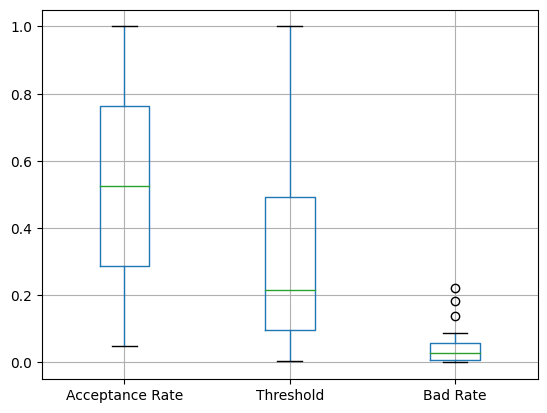

In [135]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()
plt.show()


In [136]:
# Initialize an empty list to store the number of accepted loans for each threshold
num_accepted_loans_list = []

# Iterate over each threshold in the 'Threshold' column of strat_df
for threshold in strat_df['Threshold']:
    # Compute binary predictions using the current threshold
    y_pred_non_default = (final_model.predict_proba(X_test)[:, 1] < threshold).astype(int)

    # Count the number of accepted loans (where non-default is predicted)
    num_accepted_loans = np.sum(y_pred_non_default)

    # Append the count to the list
    num_accepted_loans_list.append(num_accepted_loans)

# Assign the list of counts to the 'Num Accepted Loans' column in strat_df
strat_df['Num Accepted Loans'] = num_accepted_loans_list

strat_df['Avg Loan Amnt'] = avg_loan

strat_df['Estimated Value'] = strat_df['Num Accepted Loans'] * strat_df['Avg Loan Amnt'] * (1-strat_df['Bad Rate']-strat_df['Bad Rate'])

In [137]:
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  Avg Loan Amnt  \
0              1.00      1.000     0.223                5893    9592.393518   
1              0.95      0.994     0.183                5607    9592.393518   
2              0.90      0.981     0.137                5307    9592.393518   
3              0.85      0.901     0.088                5009    9592.393518   
4              0.80      0.590     0.065                4714    9592.393518   
5              0.75      0.459     0.056                4415    9592.393518   
6              0.70      0.373     0.046                4125    9592.393518   
7              0.65      0.314     0.039                3830    9592.393518   
8              0.60      0.270     0.033                3537    9592.393518   
9              0.55      0.231     0.029                3239    9592.393518   
10             0.50      0.202     0.026                2941    9592.393518   
11             0.45      0.174     0.020            

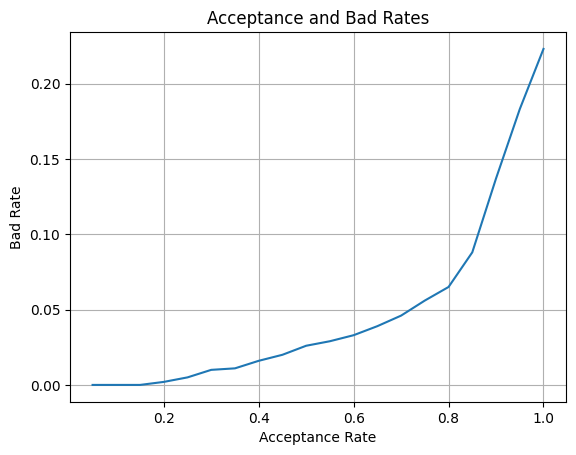

In [138]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'],
         strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.grid(True)  # Add grid lines
plt.show()

In [139]:
# Print the row with the max estimated value
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

   Acceptance Rate  Threshold  Bad Rate  Num Accepted Loans  Avg Loan Amnt  \
3             0.85      0.901     0.088                5009    9592.393518   

   Estimated Value  
3     3.959180e+07  


In [140]:
## Total expected loss
# Print the first five rows of the data frame
print(test_summary_df.head())

# Calculate the bank's expected loss and assign it to a new column
test_summary_df['expected_loss'] = test_summary_df['prob_default'] * 1 * test_summary_df['loan_amnt']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_summary_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss of default: ', '${:,.2f}'.format(tot_exp_loss))
print('Total loss of default: ', '${:,.2f}'.format(np.sum(test_summary_df['true_loan_status'] * test_summary_df['loan_amnt'])))

       true_loan_status  prob_default  pred_loan_status  loan_amnt
16239                 0      0.517472                 1       7000
8358                  1      0.880096                 1       7500
14335                 1      0.997370                 1      14500
8104                  0      0.006527                 1      11000
366                   1      0.991953                 1       4375
Total expected loss of default:  $19,757,146.02
Total loss of default:  $14,101,050.00


## Recalibration process
https://towardsdatascience.com/a-comprehensive-guide-on-model-calibration-part-1-of-4-73466eb5e09a

In [141]:
! pip install ml_insights

In [142]:
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
import ml_insights as mli

#preds_uncalibrated_test = final_model.predict_proba(X_test)[:, 1]
#print(f"XGB logloss on the test set: {log_loss(y_test, preds_uncalibrated_test):.5f}")
#print(f"XGB ROC-AUC on the test set: {roc_auc_score(y_test, preds_uncalibrated_test):.5f}")
#print(f"XGB F1 on the test set: {f1_score(y_test, final_model.predict(X_test)):.5f}")
#print()
#plt.figure(figsize=(15,5))
#rd = mli.plot_reliability_diagram(y_test, preds_uncalibrated_test,show_histogram=True)